<a href="https://colab.research.google.com/github/shauryasingh000/Diabetes_prediction_using_MachineLearning/blob/main/Diabetes_dataset_KNN_imputer_and_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pima-indians-diabetes-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F228%2F482%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T090422Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8cca15ed6654efa25e3636bb24881bbaf52f1ff6e1a6875de35ae72d96b13d5d3ad47686cae57f0ad85af93ca4c614b5391e3b5fdc6f76e7328c289591d36faa798053468a117d743501bf6681d6e418efb8a0e0903842910d50069a7a0a86dfe91a1f25dd1eec3c6d624d8ae61aaf0c34a997496eedba5729f26fc1db593f5a9d5d2e3894fb7e61ecfb0d8fe5809bb5066cf79d50dc4f84d987bc62ceb9e1c3dae4ac05b0177be69b1de2dd1a9e285c111cef7c2dc3ab20811dd8b460c3f6b34761e998c227ad3bc0cd430c2cf1874d184fc79291b6d6c449cab42e907b322c49941bb2ea0fedd2e188abcea73092fe2d735e9e0fa0c3836634c9142f2e55bb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9128 bytes downloaded
Downloaded and uncompressed: pima-indians-diabetes-database
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [3]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
data


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
 data.describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df =data.copy(deep = True)
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
595,0,188.0,82.0,14.0,185.0,32.0,0.682,22,1
606,1,181.0,78.0,42.0,293.0,40.0,1.258,22,1
155,7,152.0,88.0,44.0,NaN,50.0,0.337,36,1
180,6,87.0,80.0,NaN,NaN,23.2,0.084,32,0
589,0,73.0,NaN,NaN,NaN,21.1,0.342,25,0


In [7]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [8]:
num_df = df.select_dtypes(include='number')
corr_mat =num_df.corr()
corr_mat


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
Glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


<Axes: >

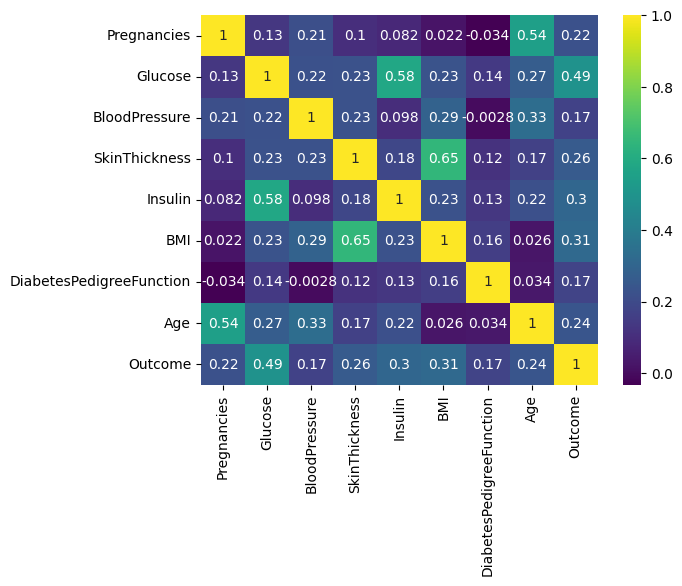

In [10]:
sns.heatmap(data = corr_mat,annot = True,cmap='viridis')

In [11]:
# Commented out due to large resourece utilization
#sns.pairplot(df,hue = 'Outcome',palette = 'flare')



In [12]:
px.scatter_3d(df,x='Glucose',y='Age',z='Insulin',color = 'Outcome')

In [13]:
px.scatter_3d(df,x='BMI',y='SkinThickness',z='Glucose',color='Pregnancies')

#  Checking The Skewness of each Column

In [14]:
for i in df.columns:
    print(i,df[i].skew())

Pregnancies 0.9016739791518588
Glucose 0.5309885349396285
BloodPressure 0.13415273171959252
SkinThickness 0.690619013984192
Insulin 2.166463843812443
BMI 0.5939697505712673
DiabetesPedigreeFunction 1.919911066307204
Age 1.1295967011444805
Outcome 0.635016643444986


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

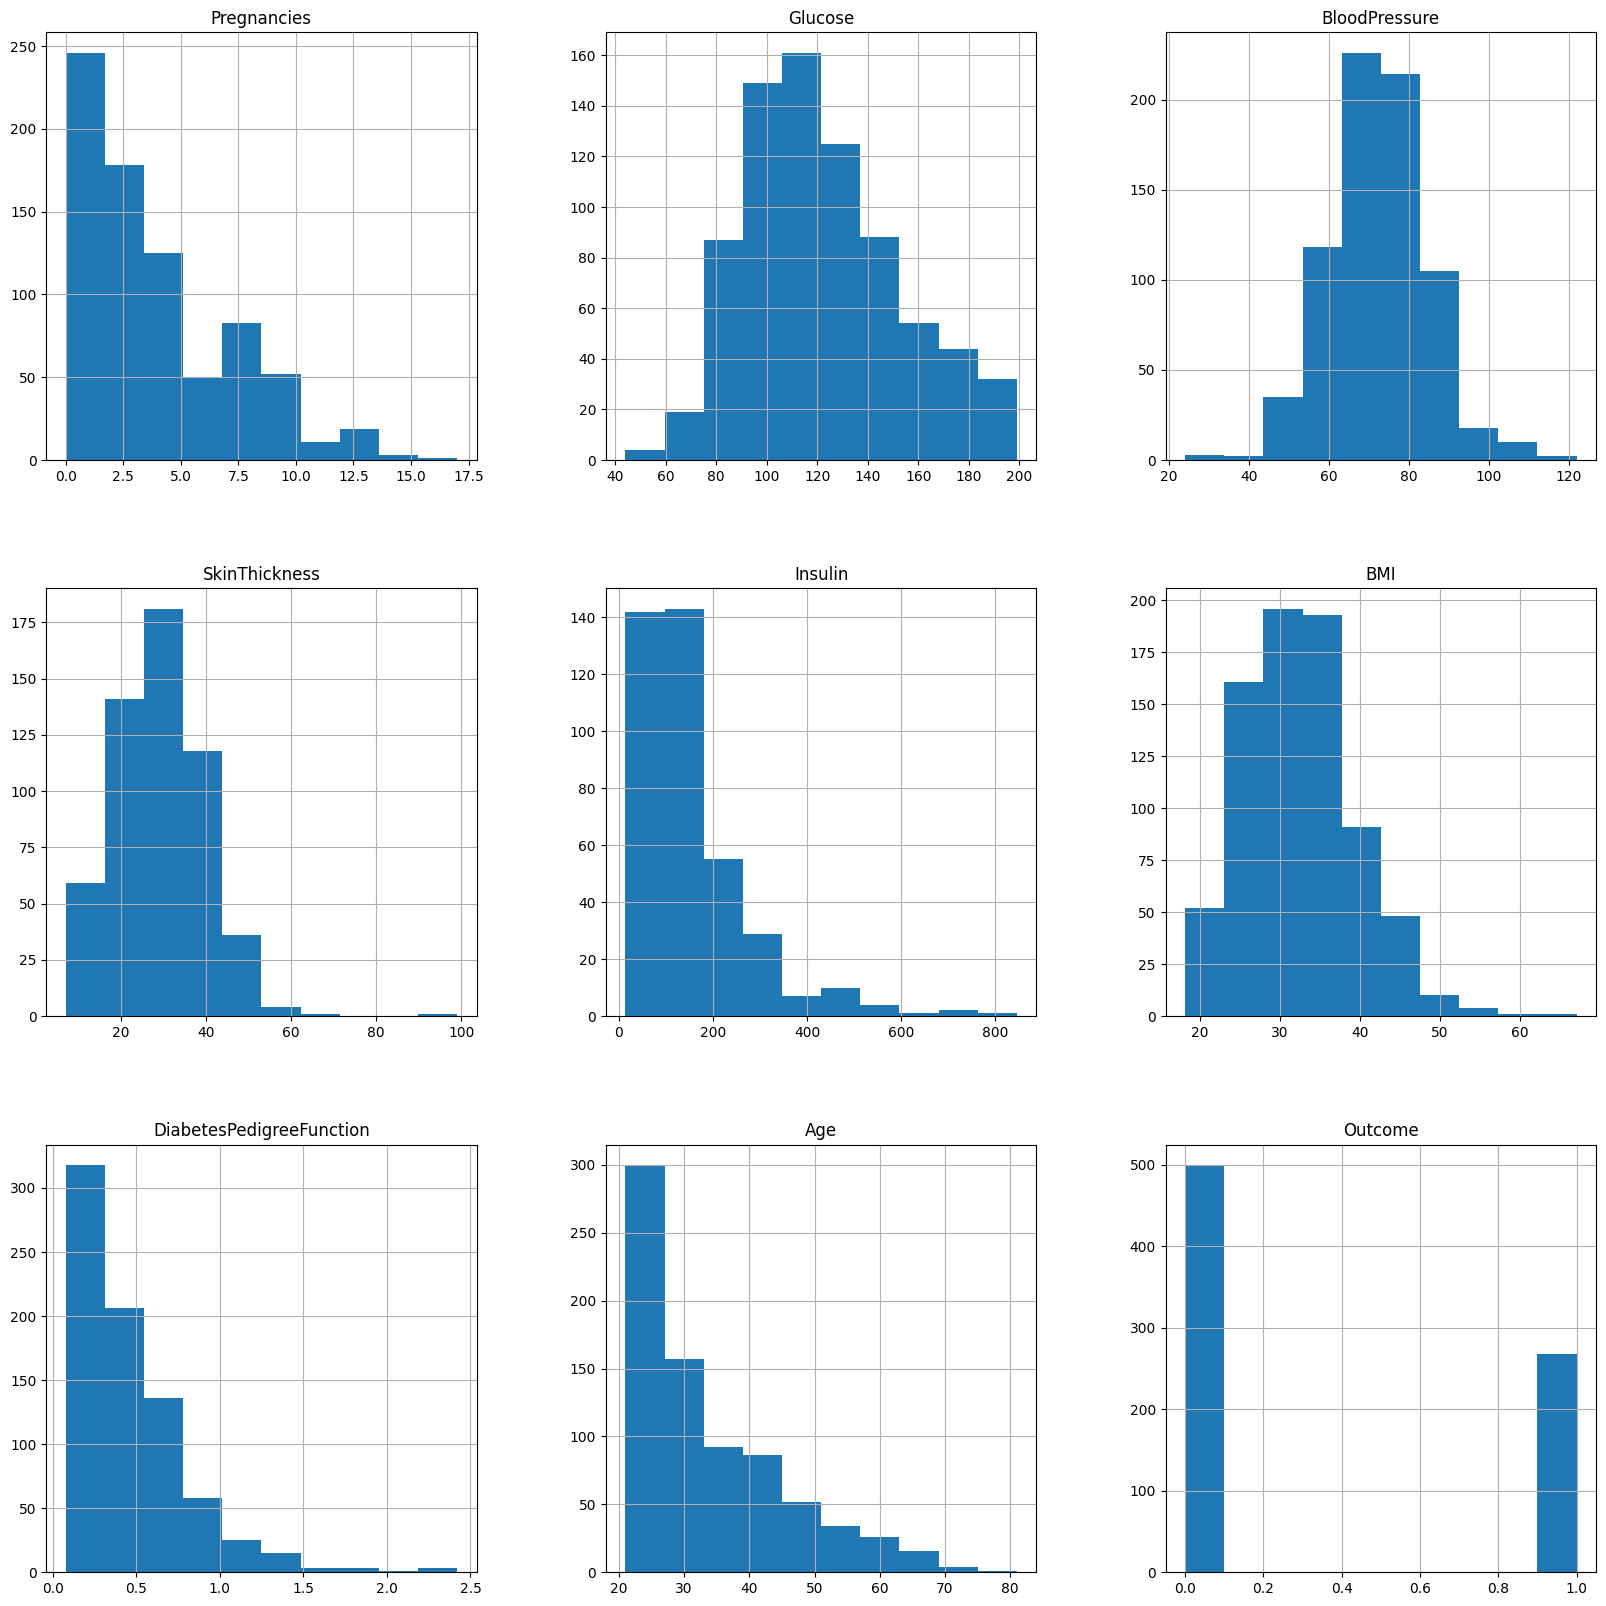

In [15]:
df.hist(figsize=(20,20))

# For Imputing NAN values we use KNN Imputer

In [16]:
from sklearn.impute import KNNImputer
kni = KNNImputer(n_neighbors=6)

df = pd.DataFrame(kni.fit_transform(df),columns =df.columns)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,178.833333,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.000000,58.000000,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,26.500000,167.166667,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.000000,165.000000,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,32.666667,135.166667,30.1,0.349,47.0,1.0


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

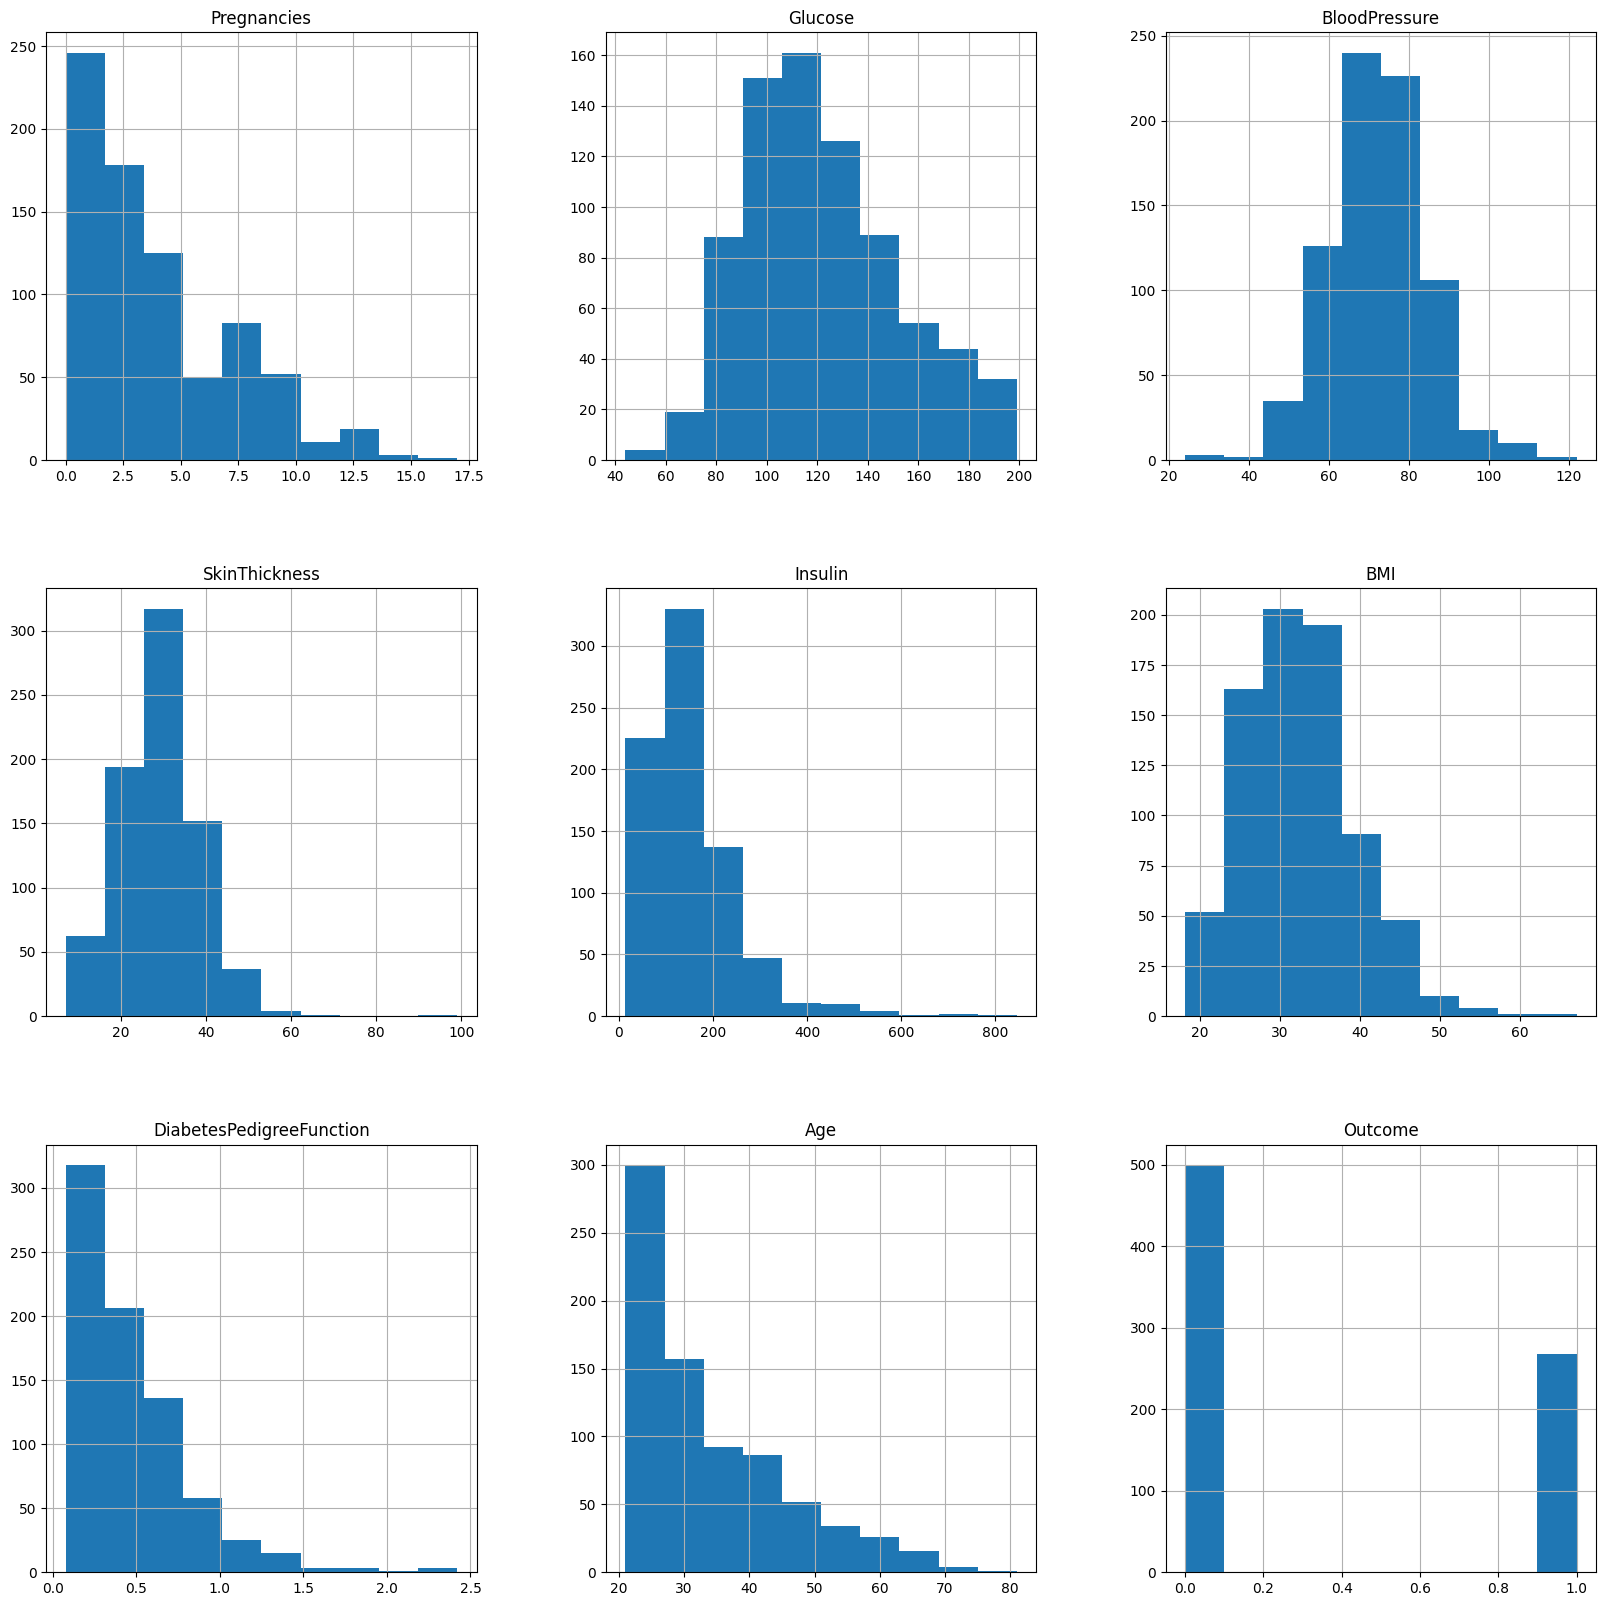

In [17]:
df.hist(figsize = (20,20))

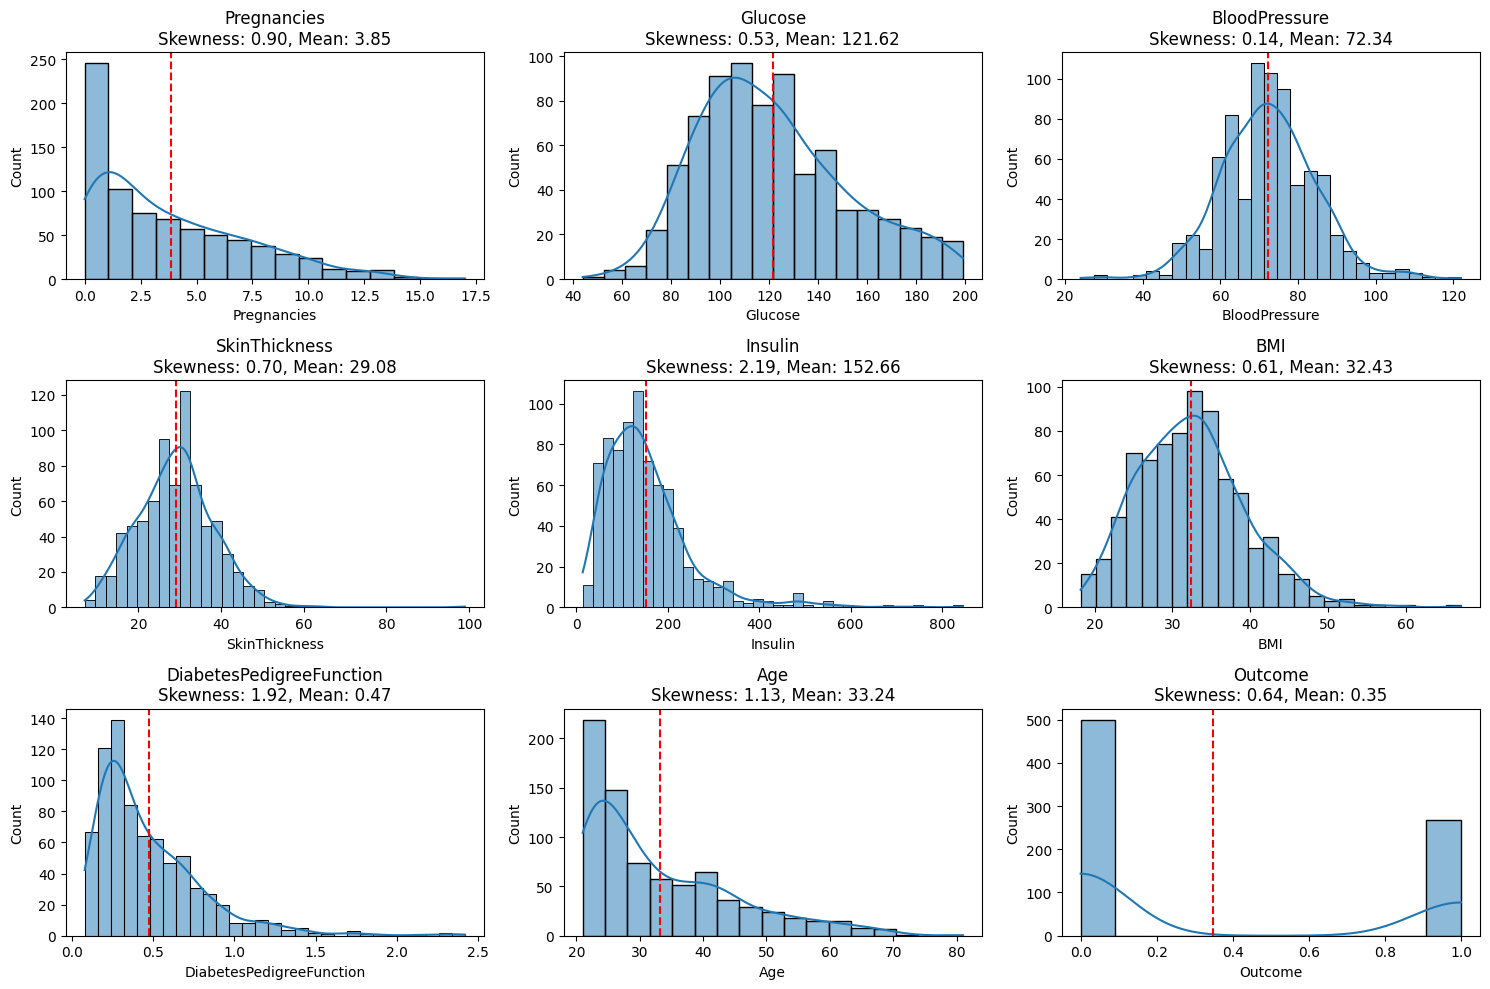

In [18]:
from scipy.stats import skew

skewed = df.skew()
means = df.mean()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].axvline(means[col], color='r', linestyle='--', label=f'Mean: {means[col]:.2f}')
    axes[i].set_title(f'{col}\nSkewness: {skewed[col]:.2f}, Mean: {means[col]:.2f}')

plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Outcome'])
y =df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,2.0,84.0,61.666667,23.833333,72.500000,30.466667,0.304,21.0
618,9.0,112.0,82.000000,24.000000,207.666667,28.200000,1.282,50.0
346,1.0,139.0,46.000000,19.000000,83.000000,28.700000,0.654,22.0
294,0.0,161.0,50.000000,26.500000,222.500000,21.900000,0.254,65.0
231,6.0,134.0,80.000000,37.000000,370.000000,46.200000,0.238,46.0
...,...,...,...,...,...,...,...,...
71,5.0,139.0,64.000000,35.000000,140.000000,28.600000,0.411,26.0
106,1.0,96.0,122.000000,28.000000,72.666667,22.400000,0.207,27.0
270,10.0,101.0,86.000000,37.000000,135.166667,45.600000,1.136,38.0
435,0.0,141.0,69.166667,34.166667,199.500000,42.400000,0.205,29.0


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scl = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test_scl = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

display(X_train_scl,X_test_scl)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.526397,-1.252382,-0.861204,-0.541832,-0.800955,-0.271057,-0.490735,-1.035940
1,1.588046,-0.323777,0.808726,-0.523285,0.558048,-0.598020,2.415030,1.487101
2,-0.828460,0.571664,-2.147870,-1.079707,-0.695385,-0.525895,0.549161,-0.948939
3,-1.130523,1.301282,-1.819360,-0.245074,0.707186,-1.506784,-0.639291,2.792122
4,0.681856,0.405842,0.644470,0.923414,2.190191,1.998450,-0.686829,1.139095
...,...,...,...,...,...,...,...,...
609,0.379793,0.571664,-0.669572,0.700845,-0.122291,-0.540320,-0.172824,-0.600933
610,-0.828460,-0.854408,4.093832,-0.078147,-0.799279,-1.434660,-0.778934,-0.513932
611,1.890109,-0.688586,1.137236,0.923414,-0.170887,1.911901,1.981245,0.443084
612,-1.130523,0.637993,-0.245246,0.608108,0.475938,1.450306,-0.784877,-0.339929


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.681856,-0.788079,-1.162338,0.478276,0.380422,0.238621,-0.116372,0.878091
1,-0.526397,-0.323777,0.233832,0.366991,-0.192671,0.483843,-0.954231,-1.035940
2,-0.526397,-0.456435,-0.669572,-0.003957,-0.308296,-0.222974,-0.924520,-1.035940
3,1.285983,-0.489599,0.644470,-0.356358,-0.325053,-1.117313,1.149329,0.095078
4,0.983919,0.472171,1.465747,0.404086,0.454153,-0.352798,-0.770021,1.487101
...,...,...,...,...,...,...,...,...
149,1.588046,1.433940,1.301492,0.571013,0.192742,-0.280673,-0.496677,1.400099
150,-0.828460,-1.484533,-1.326594,0.144422,-0.966850,0.137647,2.322925,-0.774936
151,1.285983,-0.887573,-0.012551,0.608108,-0.222834,0.642516,0.047040,2.096111
152,-0.526397,0.803815,-0.176806,1.034698,2.089648,-0.626869,-0.392688,-0.339929


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': np.arange(1, 70)}

knn_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

knn_cv.fit(X_train_scl, y_train)

print("Best Score: {:.2f}".format(knn_cv.best_score_))
print("Best Parameters: {}".format(knn_cv.best_params_))

best_model = knn_cv.best_estimator_
test_score = best_model.score(X_test_scl, y_test)
print("Test Score: {:.2f}".format(test_score))

Best Score: 0.77
Best Parameters: {'knn__n_neighbors': 22}
Test Score: 0.75


In [22]:
knn = KNeighborsClassifier()

k_values = range(1,70)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scl, y_train)

    train_pred = knn.predict(X_train_scl)
    test_pred = knn.predict(X_test_scl)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

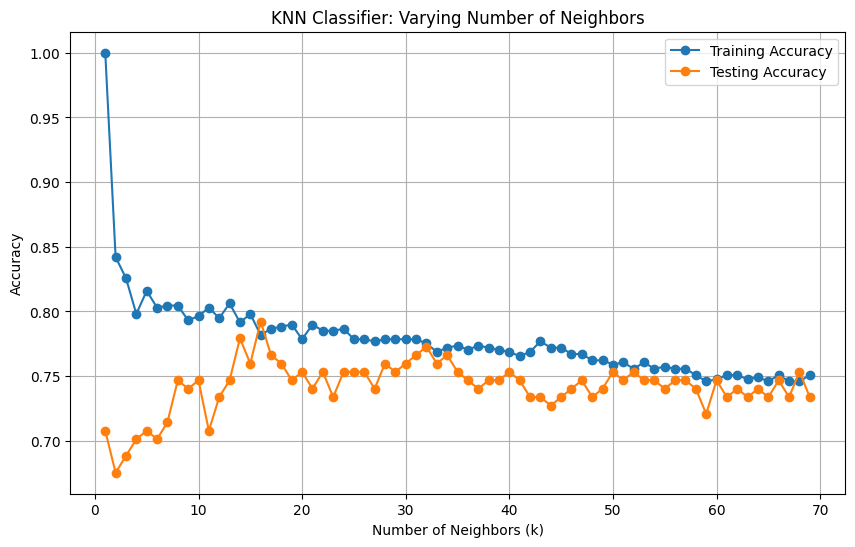

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, marker='o', label='Training Accuracy')
plt.plot(k_values, test_scores, marker='o', label='Testing Accuracy')
plt.title('KNN Classifier: Varying Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
knn = KNeighborsClassifier(n_neighbors = 16)
knn.fit(X_train_scl,y_train)
y_pred = knn.predict(X_test_scl)
y_proba = knn.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.7922077922077922


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
cross_val_score(knn, X_train_scl, y_train, cv=10,scoring = 'accuracy').mean()


0.7606292966684294

In [27]:
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,87,12,99
1.0,20,35,55
All,107,47,154


In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        99
         1.0       0.74      0.64      0.69        55

    accuracy                           0.79       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



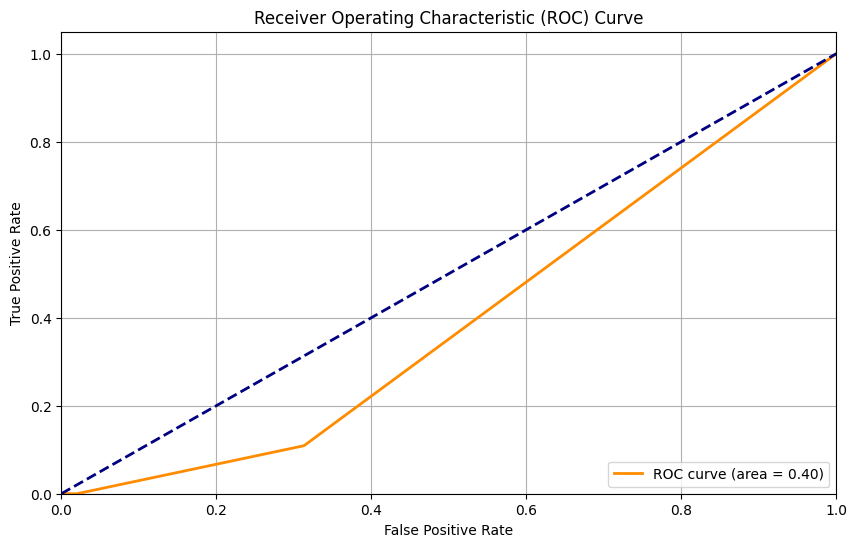

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()